# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](landmark_images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [63]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import helper
import PIL
import cv2
import os
import glob
import re

import torch
from torchvision import datasets, models, transforms

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision.utils import make_grid
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="landmark_images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

In [2]:
ROOT_DIR = 'landmark_images'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')

***
**Check picture sizes**
***

In [3]:
def print_data(data):
    """
    Parameters
    ----------
    data : dict
    """
    for k, v in data.items():
        print("%s:\t%s" % (k, v))
    print("Min width: %i" % data['min_width'])
    print("Max width: %i" % data['max_width'])
    print("Min height: %i" % data['min_height'])
    print("Max height: %i" % data['max_height'])

In [4]:
files = glob.glob(TRAIN_DIR + '/**/*.jpg', recursive=True)


data = {}
data['images_count'] = len(files)
data['min_width'] = 10**100  # No image will be bigger than that
data['max_width'] = 0
data['min_height'] = 10**100  # No image will be bigger than that
data['max_height'] = 0
df = pd.DataFrame(columns = ['index','min_width','max_width','min_height','max_height'])
i=1
for filename in files:
    im = PIL.Image.open(filename)
    width, height = im.size
    data['min_width'] = min(width, data['min_width'])
    data['max_width'] = max(width, data['max_width'])
    data['min_height'] = min(height, data['min_height'])
    data['max_height'] = max(height, data['max_height'])
    df.loc[i] = [i, min(width, data['min_width']),max(width, data['max_width']), min(height, data['min_height']), max(height, data['max_height'])] 
    i+=1
    
print_data(data)

images_count:	4996
min_width:	225
max_width:	800
min_height:	60
max_height:	800
Min width: 225
Max width: 800
Min height: 60
Max height: 800


It seems the maximum image size is (800x800) and the minimum image size is (60x225). 

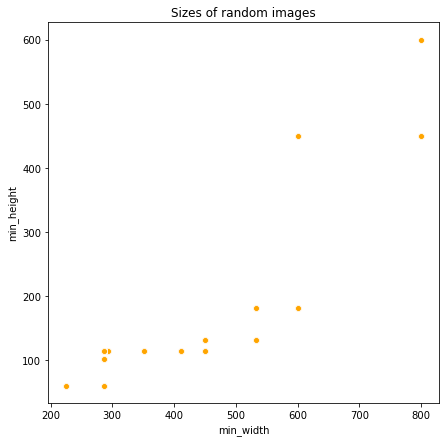

In [7]:
plt.figure(figsize=(7,7))
sns.scatterplot(x='min_width', y='min_height', data=df, color='orange')
plt.title("Sizes of random images")
plt.show()

In [8]:
IMG_SIZE = 128

In [9]:
# define transformations that will be applied to images
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.ToTensor()])

In [10]:
# load the training and test datasets
train_set = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_set = datasets.ImageFolder(TEST_DIR, transform=transform)

In [11]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers,shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers,shuffle=True)

In [12]:
## check sizes are all equal
# for batch_images, targets in train_loader:
#     print(batch_images.shape)

***
**Visualize the Data**
***

In [15]:
def get_classname_from_label(label):

    directory_list = list()
    for root, dirs, files in os.walk(TRAIN_DIR, topdown=False):
        for name in dirs:
            directory_list.append(os.path.join(root, name))

    
    keyword = label.item()
    if keyword<10:
        keyword = '0' + str(keyword) 
    else:
        keyword = str(keyword)
    keyword = keyword + "."

    dirn = [dirname for dirname in directory_list if re.search(keyword, dirname)][0]

    return dirn[dirn.find(keyword)+3:]

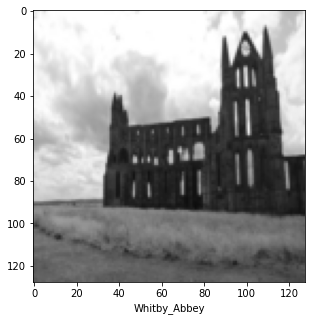

In [16]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])
img = np.transpose(img, (1, 2, 0))
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.set_xlabel(get_classname_from_label(labels[0]))
ax.imshow(img, cmap='gray')

***
**Check distribution of classes**
***

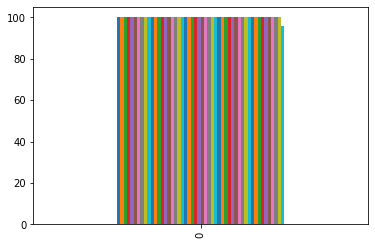

In [45]:
from collections import Counter
d = Counter(train_set.targets)
key = d.keys()

df = pd.DataFrame(d,index=key)
df.drop(df.columns[1:], inplace=True)
df.plot(kind='bar', legend=False)

The classes seem to be well-balanced.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [18]:
transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             ]),
        'valid': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.ToTensor(),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.ToTensor(),
             ])}

In [19]:
# load the training and test datasets
train_set = datasets.ImageFolder(TRAIN_DIR, transform=transform_dict['train'])
test_set = datasets.ImageFolder(TEST_DIR, transform=transform_dict['test'])

In [21]:
# % of training set to use as validation
valid_size = 0.2

In [22]:
# obtain indices that will be used for validation
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [23]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [24]:
# number of subprocesses to use for data loading
num_workers = 0
# number of samples per batch to load
batch_size = 20

In [26]:
# prepare data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, sampler = train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_set, batch_size=batch_size, sampler = valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers,shuffle=True)

In [27]:
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

- The code resizes the images to a (128, 128) image size. As seen in the previous cells, this seems to be a good size that covers most of the photos, as there are very few images with sizes smaller than that. Another reason to reduce the image size is the number of parameters: for an image size of 128x128x3 we will have 49'152 parameters. If we would go for the bigger image sizes like 800x800 this will increase the number of parameters to 720'000.
- I've decided to apply some minor image augmentation only since the picture are not all normalized, in some cases the landmark is not properly centered so the idea is to compensate for that using random horizontal flips. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

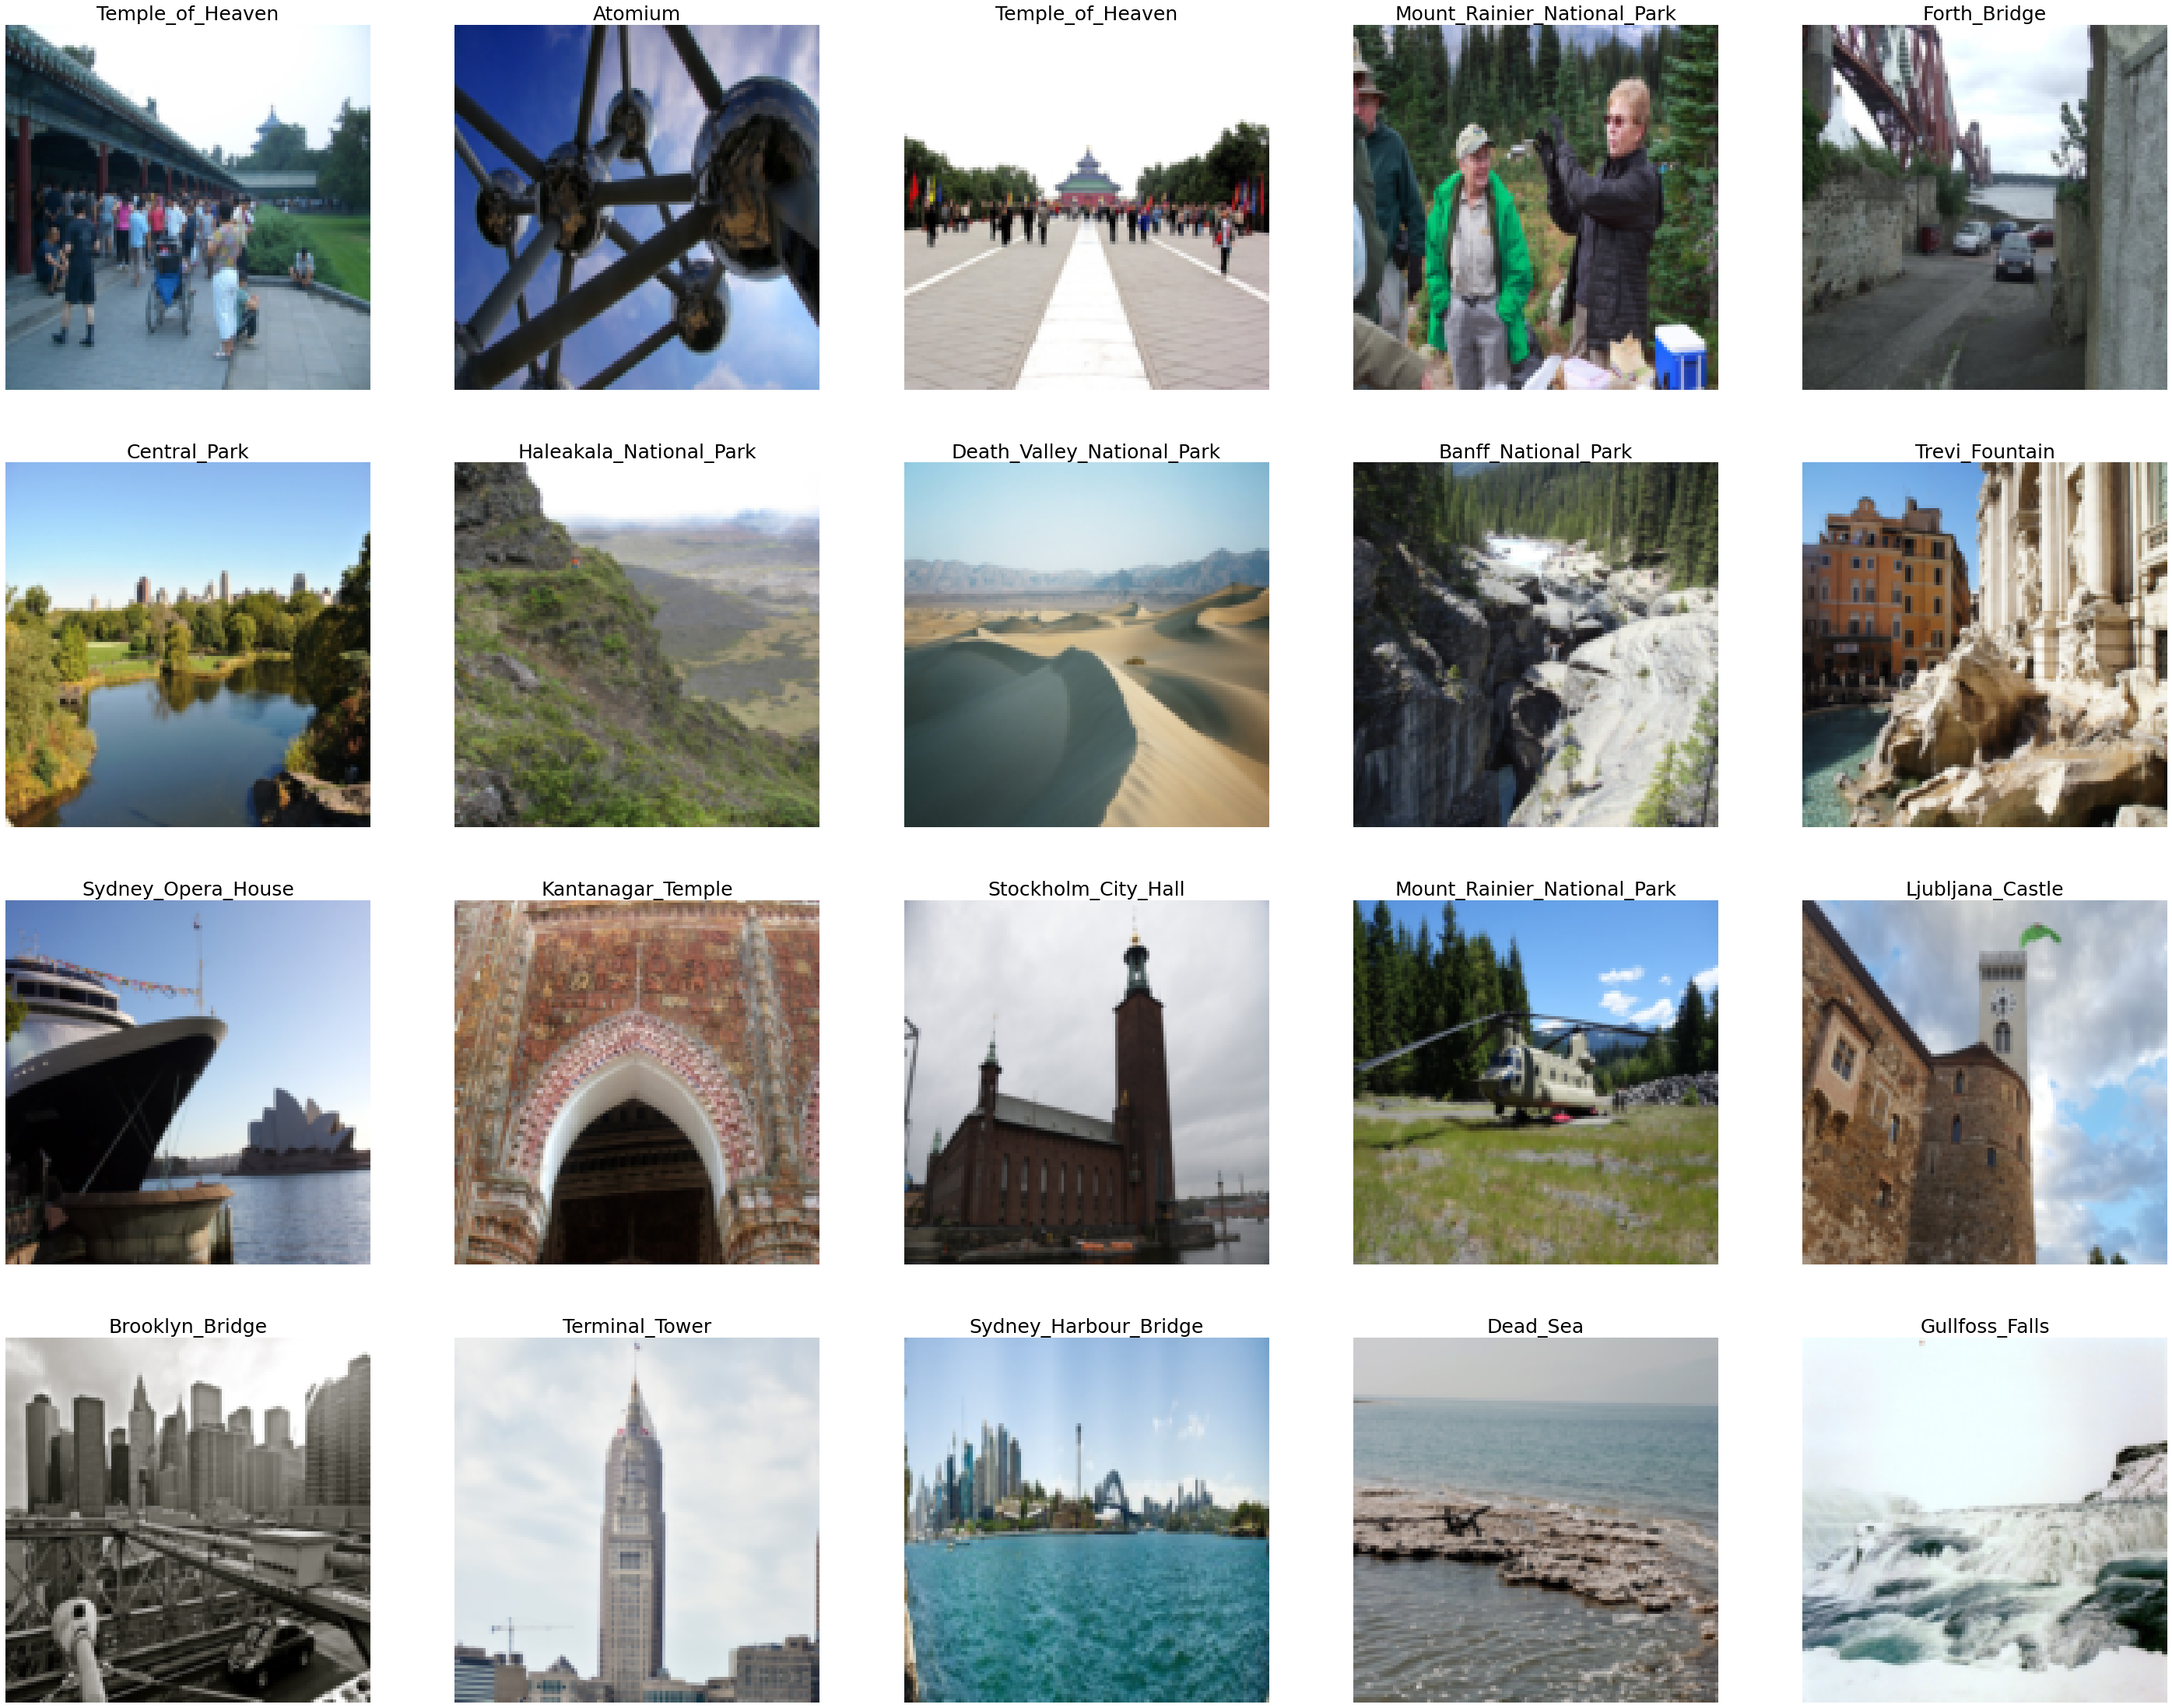

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

count_stop = 20
plt.figure(figsize=(50,50))
for i, batch in enumerate(train_loader, start=1):
    image, label = batch
    img = np.squeeze(image[0])
    img = np.transpose(img, (1, 2, 0))

    plt.subplot(5,5,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(get_classname_from_label(label[0]), fontsize=25)

    if (i >= count_stop): break
plt.show()

### Initialize use_cuda variable

In [29]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [72]:
## select loss function
criterion_scratch = CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## select and return an optimizer
    return  Adam(model.parameters(), lr=0.0001)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [73]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self, constant_weight=None):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # cheatsheet
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
        #           padding=0, dilation=1, groups=1, bias=True)
        
        # conv layer (input: 128x128x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # conv layer (input 64x64x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # conv layer (input: 32x32x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # conv layer (input: 16x16x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer 
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        # linear layer 
        self.fc2 = nn.Linear(1024, 256)
        # linear layer 
        self.fc3 = nn.Linear(256, 128)
        # linear layer
        self.fc4 = nn.Linear(128, 50)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        # initialize the weights to a specified, constant value
        if(constant_weight is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)
    

    def forward(self, x):
        ## Define forward behavior

        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # flatten image input
        x = x.view(-1, 128 * 8 * 8)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rdd hidden layer, with relu activation function
        x = F.relu(self.fc3(x))
        # add dropout layer
        x = self.dropout(x)

        x = self.fc4(x)
        return x
        

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

The model architecture is a 4 layer convolutional neural network, with uses of dropout, max pooling and ReLU activation function.

First, the model passes the image to the first convolutional layer, with the input being a 128x128x3 tensor. This first convolutional layer has input channel of 3 and output channel of 16, filter size of 3. Then it comes to a max-pool layer of size 2. Max pooling is a layer that will have stride size same as filter size. Then it’s passed to a ReLU activation function. Next, I specify a drop-out layer to avoid over-fitting in the model. 

The more convolutional layers we include, the more complex patterns in color and shape a model can detect, so I decided to go for 4 such convolution and pooling blocks. 

After the convolutional part is done, I “flattened” the array into a one-dimensional array, and put it through four fully-connected layers, finally obtaining an output.

I initially started with a LeCunn architecture which only resulted in a 2% test accuracy and added more convolutional/pooling blocks anf fully connected layers to increase accuracy.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [74]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        # intialize variables to calculate validation accuracy per epoch
        correct = 0.0
        total = 0.0    

    
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
         
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## update average validation loss 

            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
#             valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
    
        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)     
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        print('Validation Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
        
        ## if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss      
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [36]:
def custom_weight_init(m):
    ## implement a uniform weight initialization strategy
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)
        

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 0.000988 	Validation Loss: 0.003946
Validation loss decreased (inf --> 0.003946).  Saving model ...
Epoch: 2 	Training Loss: 0.000986 	Validation Loss: 0.003939
Validation loss decreased (0.003946 --> 0.003939).  Saving model ...
Epoch: 3 	Training Loss: 0.000986 	Validation Loss: 0.003956
Epoch: 4 	Training Loss: 0.000987 	Validation Loss: 0.003938
Validation loss decreased (0.003939 --> 0.003938).  Saving model ...
Epoch: 5 	Training Loss: 0.000987 	Validation Loss: 0.003948
Epoch: 6 	Training Loss: 0.000986 	Validation Loss: 0.003935
Validation loss decreased (0.003938 --> 0.003935).  Saving model ...
Epoch: 7 	Training Loss: 0.000986 	Validation Loss: 0.003937
Epoch: 8 	Training Loss: 0.000986 	Validation Loss: 0.003937
Epoch: 9 	Training Loss: 0.000987 	Validation Loss: 0.003941
Epoch: 10 	Training Loss: 0.000987 	Validation Loss: 0.003951
Epoch: 11 	Training Loss: 0.000986 	Validation Loss: 0.003940
Epoch: 12 	Training Loss: 0.000987 	Validation Loss: 0.0

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [75]:
num_epochs = 50

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 0.000979 	Validation Loss: 0.003918
Validation Accuracy:  2% (29/999)
Validation loss decreased (inf --> 0.003918).  Saving model ...
Epoch: 2 	Training Loss: 0.000974 	Validation Loss: 0.003837
Validation Accuracy:  4% (41/999)
Validation loss decreased (0.003918 --> 0.003837).  Saving model ...
Epoch: 3 	Training Loss: 0.000950 	Validation Loss: 0.003757
Validation Accuracy:  6% (66/999)
Validation loss decreased (0.003837 --> 0.003757).  Saving model ...
Epoch: 4 	Training Loss: 0.000932 	Validation Loss: 0.003689
Validation Accuracy:  8% (85/999)
Validation loss decreased (0.003757 --> 0.003689).  Saving model ...
Epoch: 5 	Training Loss: 0.000917 	Validation Loss: 0.003635
Validation Accuracy:  9% (92/999)
Validation loss decreased (0.003689 --> 0.003635).  Saving model ...
Epoch: 6 	Training Loss: 0.000900 	Validation Loss: 0.003603
Validation Accuracy: 10% (103/999)
Validation loss decreased (0.003635 --> 0.003603).  Saving model ...
Epoch: 7 	Training L

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [76]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.0
    correct = 0.0
    total = 0.0

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.781937


Test Accuracy: 31% (388/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [77]:
# VGG-16 Takes 224x224 images as input, so we resize all of them to 224
IMG_SIZE = 224

In [78]:
transform_dict = {
        'train': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             ]),
        'valid': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.ToTensor(),
             ]),
        'test': transforms.Compose(
            [transforms.Resize((IMG_SIZE, IMG_SIZE)),
             transforms.ToTensor(),
             ])}

In [79]:
# load the training and test datasets
train_set = datasets.ImageFolder(TRAIN_DIR, transform=transform_dict['train'])
test_set = datasets.ImageFolder(TEST_DIR, transform=transform_dict['test'])

In [80]:
# % of training set to use as validation
valid_size = 0.2

In [81]:
# obtain indices that will be used for validation
num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [82]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [83]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

In [84]:
# prepare data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, sampler = train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_set, batch_size=batch_size, sampler = valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=num_workers,shuffle=True)

In [85]:
loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [143]:
# ## select loss function
criterion_transfer = CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## select and return optimizer
    return  Adam(model.parameters(), lr=0.0001)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [144]:
# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)

# print out the model structure
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [145]:
print(model_transfer.classifier[6].in_features) 
print(model_transfer.classifier[6].out_features) 

4096
1000


In [146]:
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

In [147]:
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 50 classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 50)

model_transfer.classifier[6] = last_layer


# check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)

50


In [148]:
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

I have chosen the VGG16 architecture trained on Imagenet dataset and will use it to predict on the images that we have. Observation: Imagenet weights are successfully able to capture the generic features from landmarks.

The idea here is that we keep all the convolutional layers, but replace the final fully-connected layer with our own classifier. This way we can use VGGNet as a fixed feature extractor for our images then easily train a simple classifier on top of that. Here I have chosen the simplest way to just replace the last layer with a fully connected layer. 

There are a couple of reasons why a simple model is preferred over a complex model, but here I decided for the simplest model to improve the computational efficiency.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [150]:
# train the model and save the best model parameters at filepath 'model_transfer.pt'
optimizer = get_optimizer_transfer(model_transfer)
# number of epochs to train the model
n_epochs = 10

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf 
    
for epoch in range(1, n_epochs+1):
    # initialize variables to monitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    # intialize variables to calculate validation accuracy per epoch
    correct = 0.0
    total = 0.0         
    ###################
    # train the model #
    ###################
    # set the module to training mode
    model_transfer.train()
    for batch_idx, (data, target) in enumerate(loaders_transfer['train']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        ## find the loss and update the model parameters accordingly
        ## record the average training loss, using something like
        ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))          

    ######################    
    # validate the model #
    ######################
    # set the model to evaluation mode
    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(loaders_transfer['valid']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        ## update average validation loss 

        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion_transfer(output, target)
        # update average validation loss 
#             valid_loss += loss.item()*data.size(0)
        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)     
            

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

    print('Validation Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
        
    ## if the validation loss has decreased, save the model at the filepath stored in save_path
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model_transfer.state_dict(), 'model_transfer.pt')
        valid_loss_min = valid_loss  
            
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.000590 	Validation Loss: 0.001596
Validation Accuracy: 58% (588/999)
Validation loss decreased (inf --> 0.001596).  Saving model ...
Epoch: 2 	Training Loss: 0.000307 	Validation Loss: 0.001364
Validation Accuracy: 64% (640/999)
Validation loss decreased (0.001596 --> 0.001364).  Saving model ...
Epoch: 3 	Training Loss: 0.000179 	Validation Loss: 0.001282
Validation Accuracy: 67% (678/999)
Validation loss decreased (0.001364 --> 0.001282).  Saving model ...
Epoch: 4 	Training Loss: 0.000105 	Validation Loss: 0.001315
Validation Accuracy: 67% (672/999)
Epoch: 5 	Training Loss: 0.000065 	Validation Loss: 0.001330
Validation Accuracy: 68% (680/999)
Epoch: 6 	Training Loss: 0.000045 	Validation Loss: 0.001364
Validation Accuracy: 67% (678/999)
Epoch: 7 	Training Loss: 0.000029 	Validation Loss: 0.001410
Validation Accuracy: 68% (684/999)
Epoch: 8 	Training Loss: 0.000020 	Validation Loss: 0.001401
Validation Accuracy: 67% (677/999)
Epoch: 9 	Training Loss: 0.000

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [151]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.041380


Test Accuracy: 73% (913/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [152]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # Open the image
    pil_image = Image.open(image_path)
    
    # Resize the image
    if pil_image.size[1] < pil_image.size[0]:
        pil_image.thumbnail((255, math.pow(255, 2)))
    else:
        pil_image.thumbnail((math.pow(255, 2), 255))
                            
    # Crop the image
    left = (pil_image.width-224)/2
    bottom = (pil_image.height-224)/2
    right = left + 224
    top = bottom + 224
                            
    pil_image = pil_image.crop((left, bottom, right, top))
                            
    # Turn into np_array
    np_image = np.array(pil_image)/255
    
    # Undo mean and std then transpose
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])  
    np_image = (np_image - mean)/std
    np_image = np.transpose(np_image, (2, 0, 1))
    
    return np_image

In [153]:
def imshow(image, ax=None, title=''):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    plt.show(ax)
    
    return ax

In [154]:
def get_classname_from_id(keyword):

    directory_list = list()
    for root, dirs, files in os.walk(TRAIN_DIR, topdown=False):
        for name in dirs:
            directory_list.append(os.path.join(root, name))


    if keyword<10:
        keyword = '0' + str(keyword) 
    else:
        keyword = str(keyword)
    keyword = keyword + "."

    dirn = [dirname for dirname in directory_list if re.search(keyword, dirname)][0]

    return dirn[dirn.find(keyword)+3:]

In [155]:
import cv2
from PIL import Image
import math

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(image_path, topk):
    ## return the names of the top k landmarks predicted by the transfer learned CNN
    if topk < 1:
        topk = 1
        
    # load the model that got the best validation accuracy
    model_transfer.load_state_dict(torch.load('model_transfer.pt'))
    model_transfer.eval()
    with torch.no_grad():
        img = process_image(image_path)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.float()
        logps = model_transfer.forward(img)
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(topk, dim=1)
        return top_p, top_class 
    


# test on a sample image
predict_landmarks('landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

(tensor([[44.9545, 35.5559, 11.6284,  3.2534,  0.0648]]),
 tensor([[30,  9, 38, 28, 33]]))

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](landmark_images/sample_landmark_output.png)

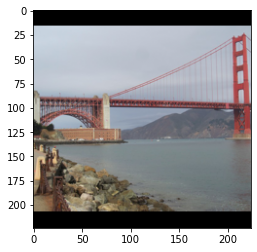


The model predicts this landmark as: 

Brooklyn_Bridge ...........44.9545364380 %
Golden_Gate_Bridge ...........35.5558853149 %
Forth_Bridge ...........11.6283569336 %


In [156]:
def suggest_locations(img_path):
    # get landmark predictions
    ## display image and display landmark predictions
    img = process_image(img_path)
    imshow(img)
  
    probs, classes = predict_landmarks('{}'.format(img_path), 3)

    print()
    print('The model predicts this landmark as: ')
    print()
    for count in range(3):
        classes_array = classes[0, count].numpy()
        print('{} ...........{:.10f} %'.format(get_classname_from_id(classes_array), probs[0, count]))
    

# test on a sample image
suggest_locations('landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

Here are some potential ways to improve the performance of the **transfer** model:
- Training the model for longer could have increased test accuracy. Since I ran the notebook locally, I could not take advantage of the GPU, so I had to limit the number of epochs.
- During the data augmentation phase, normalization may impact potential feature detection, so adding normalization and modifying the values may result in performance changes.
- Simply replacing the last layer may be overly simplistic. Adding more fully connected layers might help the model to make more accurate predictions.

Here are some potential ways to improve the performance of the **scratch** model:
- Training the model for longer could have increased test accuracy. Since I ran the notebook locally, I could not take advantage of the GPU, so I had to limit the number of epochs. But especially in this case it was obvious that the accuracy was still increasing/loss was still decreasing.
- During the data augmentation phase, normalization may impact potential feature detection, so adding normalization and modifying the values may result in performance changes.
- The architecture that I used may have oversimplified the image by pooling it twice, reducing the detail of the features, making it harder to detect patterns between images.
- For efficiency purposes, I probably didn’t need four fully-connected layers, and two or three would have likely resulted in similar values.

**Note on the performance of both models**: I tried several times, using different techniques to reach the required accuracy limit, and in the end reducing the learning rate of the Adam optimizer did the trick. For the transfer model: using a learning rate of 0.001 after 10 epochs missed the 60% accuracy threshold by 1% (I only managed to reach 59%). However, after setting the learning rate to 0.0001 it improved significantly with a considerably higher computational cost (especially on CPU). 

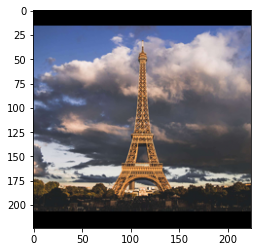


The model predicts this landmark as: 

Eiffel_Tower ...........12.4975366592 %
Vienna_City_Hall ...........1.2836161852 %
Terminal_Tower ...........0.1254212707 %


In [161]:
## Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

# test on a sample image
suggest_locations('landmark_images/sample_images/iu-1.jpg')

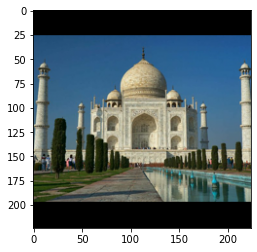


The model predicts this landmark as: 

Stockholm_City_Hall ...........17.4504051208 %
Taj_Mahal ...........0.8423228264 %
Gateway_of_India ...........0.6473290324 %


In [160]:
suggest_locations('landmark_images/sample_images/iu-2.jpg')

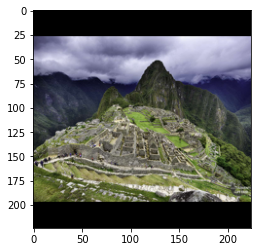


The model predicts this landmark as: 

Machu_Picchu ...........826.3174438477 %
Externsteine ...........1.3257517815 %
Edinburgh_Castle ...........0.3754608631 %


In [163]:
suggest_locations('landmark_images/sample_images/iu-3.jpg')

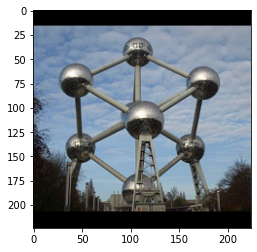


The model predicts this landmark as: 

Atomium ...........1205524.3750000000 %
Stockholm_City_Hall ...........0.0004580021 %
Niagara_Falls ...........0.0000389832 %


In [164]:
suggest_locations('landmark_images/sample_images/iu-4.jpg')

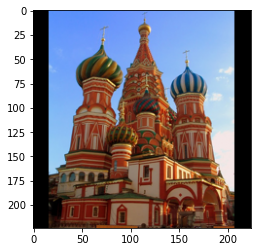


The model predicts this landmark as: 

Vienna_City_Hall ...........64.2388763428 %
Stockholm_City_Hall ...........0.5702537298 %
Gateway_of_India ...........0.0751433820 %


In [165]:
suggest_locations('landmark_images/sample_images/iu-5.jpg')

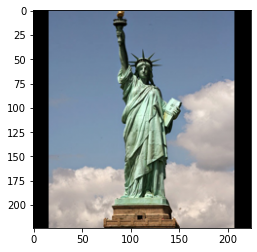


The model predicts this landmark as: 

Vienna_City_Hall ...........0.1933223307 %
Stockholm_City_Hall ...........0.1647633910 %
Gateway_of_India ...........0.0371615738 %


In [166]:
suggest_locations('landmark_images/sample_images/iu-6.jpg')